In [1]:
import pandas as pd
import os
from glob import glob
import numpy as np
from skmultilearn.model_selection import iterative_train_test_split

In [2]:
import torch
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda:0")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
We will use the GPU: NVIDIA A100-PCIE-40GB


In [3]:
# read corpora
#ambitious = pd.read_csv('../corpora/ambitious_goals.csv').drop("Unnamed: 0", axis=1)
#confidence = pd.read_csv('../corpora/confidence_in_goals.csv').drop("Unnamed: 0", axis=1)
#contrast = pd.read_csv('../corpora/contrast.csv').drop("Unnamed: 0", axis=1)
#lists = pd.read_csv('../corpora/lists_repetitions.csv').drop("Unnamed: 0", axis=1)
#similie = pd.read_csv('../corpora/metaphor_similie.csv').drop("Unnamed: 0", axis=1)
#rhetoricalq = pd.read_csv('../corpora/rhetorical_question.csv').drop("Unnamed: 0", axis=1)
#sentiment = pd.read_csv('../corpora/sentiment_of_the_collective.csv').drop("Unnamed: 0", axis=1)
#story = pd.read_csv('../corpora/story_anecdote.csv').drop("Unnamed: 0", axis=1)
vua_metaphor = pd.read_csv('../corpora/vua_metaphor.csv')
vua_metaphor = vua_metaphor[['sentence', 'label']].rename(columns={'label':'Metaphor/Similie'})
moral_conv = pd.read_csv('../corpora/moral_convictions.csv').rename(columns={'Moral_conviction':'Moral Conviction'})
generated_tactics = pd.read_csv('../corpora/all_generated_tactics.csv').drop("Unnamed: 0", axis=1)
generated_tactics['sentence'] = generated_tactics['sentence'].apply(lambda x: str(x).replace('"', ''))

In [4]:
vua_metaphor

,sentence,Metaphor/Similie
0,He was President of FISA ( Federation Internat...,1
1,Most athletes first encountered him as a voice...,0
2,Most athletes first encountered him as a voice...,1
3,Most athletes first encountered him as a voice...,1
4,Most athletes first encountered him as a voice...,1
...,...,...
23108,Aristotle said something very interesting in t...,1
23109,Aristotle said something very interesting in t...,0
23110,Aristotle said something very interesting in t...,1
23111,Aristotle said something very interesting in t...,0


In [5]:
generated_tactics['sentence']

0        Just as a conductor leads an orchestra, each s...
1        The figure of speech we find in these speeches...
2        Like an artist with a palette of colors, each ...
3        The figure of speech used by these individuals...
4        Just as a conductor leads an orchestra, each s...
                               ...                        
95073    Our shared belief in our potential will be the...
95074    Let us march forward fearlessly, knowing that ...
95075    Our collective determination to succeed will g...
95076    Together, we will transform our goals into res...
95077    I firmly believe that our shared vision holds the
Name: sentence, Length: 95078, dtype: object

In [6]:
dfs = [generated_tactics, moral_conv, vua_metaphor]#
#[ambitious, confidence, contrast, lists, similie, rhetoricalq, sentiment, story, vua_metaphor, moral_conv]
data = pd.concat(dfs, ignore_index=True).fillna(0)
#data['Results'] = data['Results'].apply(lambda x: x.replace('"',''))
#data = data.rename(columns={'Results':'sentence'})
data

,sentence,Metaphor/Similie,Rhetorical question,Story/Anecdote,Contrast,Lists/Repetitions,Sentiment of the Collective,Moral Conviction,Ambitious goals,Confidence in goals
0,"Just as a conductor leads an orchestra, each s...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,The figure of speech we find in these speeches...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Like an artist with a palette of colors, each ...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,The figure of speech used by these individuals...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Just as a conductor leads an orchestra, each s...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
124771,Aristotle said something very interesting in t...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
124772,Aristotle said something very interesting in t...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
124773,Aristotle said something very interesting in t...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
124774,Aristotle said something very interesting in t...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
from sklearn.model_selection import train_test_split
y = data.drop(columns=['sentence']).values #get the labels
train, test = train_test_split(data, test_size=0.2, random_state=1337, shuffle=True)


In [8]:
sentences = train.sentence.values
labels =  train.drop(columns=['sentence']).values

In [9]:
np.unique(labels)

array([0., 1.])

In [10]:
from transformers import BertTokenizer
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

2024-01-16 09:10:14.411541: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-16 09:10:14.578268: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-16 09:10:15.112419: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-16 09:10:15.112494: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

Loading BERT tokenizer...


In [11]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        #max_length = 128,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)
# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  When planning a DIY home improvement project, there are three main steps to follow: planning and research, gathering materials, and executing the project.
Token IDs: [101, 2043, 4041, 1037, 4487, 2100, 2188, 7620, 2622, 1010, 2045, 2024, 2093, 2364, 4084, 2000, 3582, 1024, 4041, 1998, 2470, 1010, 7215, 4475, 1010, 1998, 23448, 1996, 2622, 1012, 102]


In [12]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  220


In [13]:
# get the distribution of sentence lengths
sentences_len = [len(sen) for sen in sentences]
sentences_len[:5]

[154, 58, 146, 69, 107]

In [14]:
# We'll use the `pad_sequences` utility function to do this.
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Set the maximum sequence length.
# 149 is the mean of sequence lengths
MAX_LEN = max([len(sen) for sen in input_ids])
print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)
print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))
# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

labels = torch.tensor(labels,dtype=torch.long)
print('\Done.')


Padding/truncating all sentences to 220 values...

Padding token: "[PAD]", ID: 0
\Done.


In [15]:
# Create attention masks
attention_masks = []
# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

In [16]:
# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split
# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.1)


In [17]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

/tmp/ipykernel_3269587/268205451.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(train_labels)
/tmp/ipykernel_3269587/268205451.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_labels = torch.tensor(validation_labels)


In [18]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
batch_size = 128#*labels.shape[1] #32 # 32*11
# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [19]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = labels.shape[1], # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    problem_type="multi_label_classification",
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
#problem_type="multi_label_classification"
)
# Tell pytorch to run this model on the GPU.
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [20]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())
print('The BERT model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== First Transformer ====\n')
for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== Output Layer ====\n')
for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [21]:
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
from transformers import get_linear_schedule_with_warmup
# Number of training epochs (authors recommend between 2 and 4)
epochs = 100
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs
# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 5, # Default value in run_glue.py
                                            num_training_steps = total_steps)

/home/datasciencefhswf/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [22]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
import time
import datetime
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [23]:
print(torch.cuda.memory_summary(device=None, abbreviated=True))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  428806 KB |  428806 KB |  428806 KB |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |  428806 KB |  428806 KB |  428806 KB |       0 B  |
|---------------------------------------------------------------------------|
| GPU reserved memory   |  483328 KB |  483328 KB |  483328 KB |       0 B  |
|---------------------------------------------------------------

In [24]:
import random
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128
# Set the seed value all over the place to make this reproducible.
torch.cuda.empty_cache()
seed_val = 421337
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
# Store the average loss after each epoch so we can plot them.
loss_values = []
# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    # Reset the total loss for this epoch.
    total_loss = 0
    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()
    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        
        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels.to(torch.float))
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()
        # Update the learning rate.
        scheduler.step()
    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    print("")
    print("Running Validation...")
    t0 = time.time()
    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()
    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy
        # Track the number of batches
        nb_eval_steps += 1
    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
print("")
print("Training complete!")


======== Epoch 1 / 100 ========
Training...
  Batch    40  of    702.    Elapsed: 0:00:43.
  Batch    80  of    702.    Elapsed: 0:01:27.
  Batch   120  of    702.    Elapsed: 0:02:10.
  Batch   160  of    702.    Elapsed: 0:02:54.
  Batch   200  of    702.    Elapsed: 0:03:38.
  Batch   240  of    702.    Elapsed: 0:04:22.
  Batch   280  of    702.    Elapsed: 0:05:05.
  Batch   320  of    702.    Elapsed: 0:05:49.
  Batch   360  of    702.    Elapsed: 0:06:32.
  Batch   400  of    702.    Elapsed: 0:07:16.
  Batch   440  of    702.    Elapsed: 0:08:00.
  Batch   480  of    702.    Elapsed: 0:08:43.
  Batch   520  of    702.    Elapsed: 0:09:27.
  Batch   560  of    702.    Elapsed: 0:10:11.
  Batch   600  of    702.    Elapsed: 0:10:54.
  Batch   640  of    702.    Elapsed: 0:11:38.
  Batch   680  of    702.    Elapsed: 0:12:22.

  Average training loss: 0.08
  Training epoch took: 0:12:45

Running Validation...


/tmp/ipykernel_3269587/18900293.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  return np.sum(pred_flat == labels_flat) / len(labels_flat)


  Accuracy: 0.00
  Validation took: 0:00:29

======== Epoch 2 / 100 ========
Training...
  Batch    40  of    702.    Elapsed: 0:00:44.
  Batch    80  of    702.    Elapsed: 0:01:27.
  Batch   120  of    702.    Elapsed: 0:02:11.
  Batch   160  of    702.    Elapsed: 0:02:55.
  Batch   200  of    702.    Elapsed: 0:03:38.
  Batch   240  of    702.    Elapsed: 0:04:22.
  Batch   280  of    702.    Elapsed: 0:05:05.
  Batch   320  of    702.    Elapsed: 0:05:49.
  Batch   360  of    702.    Elapsed: 0:06:33.
  Batch   400  of    702.    Elapsed: 0:07:16.
  Batch   440  of    702.    Elapsed: 0:08:00.
  Batch   480  of    702.    Elapsed: 0:08:43.
  Batch   520  of    702.    Elapsed: 0:09:27.
  Batch   560  of    702.    Elapsed: 0:10:11.
  Batch   600  of    702.    Elapsed: 0:10:54.
  Batch   640  of    702.    Elapsed: 0:11:38.
  Batch   680  of    702.    Elapsed: 0:12:21.

  Average training loss: 0.02
  Training epoch took: 0:12:45

Running Validation...
  Accuracy: 0.00
  Validati

  Batch   320  of    702.    Elapsed: 0:05:49.
  Batch   360  of    702.    Elapsed: 0:06:32.
  Batch   400  of    702.    Elapsed: 0:07:16.
  Batch   440  of    702.    Elapsed: 0:08:00.
  Batch   480  of    702.    Elapsed: 0:08:43.
  Batch   520  of    702.    Elapsed: 0:09:27.
  Batch   560  of    702.    Elapsed: 0:10:10.
  Batch   600  of    702.    Elapsed: 0:10:54.
  Batch   640  of    702.    Elapsed: 0:11:38.
  Batch   680  of    702.    Elapsed: 0:12:21.

  Average training loss: 0.01
  Training epoch took: 0:12:45

Running Validation...
  Accuracy: 0.00
  Validation took: 0:00:29

======== Epoch 11 / 100 ========
Training...
  Batch    40  of    702.    Elapsed: 0:00:44.
  Batch    80  of    702.    Elapsed: 0:01:27.
  Batch   120  of    702.    Elapsed: 0:02:11.
  Batch   160  of    702.    Elapsed: 0:02:54.
  Batch   200  of    702.    Elapsed: 0:03:38.
  Batch   240  of    702.    Elapsed: 0:04:22.
  Batch   280  of    702.    Elapsed: 0:05:05.
  Batch   320  of    702. 

  Batch   680  of    702.    Elapsed: 0:12:21.

  Average training loss: 0.01
  Training epoch took: 0:12:45

Running Validation...
  Accuracy: 0.00
  Validation took: 0:00:29

======== Epoch 19 / 100 ========
Training...
  Batch    40  of    702.    Elapsed: 0:00:44.
  Batch    80  of    702.    Elapsed: 0:01:27.
  Batch   120  of    702.    Elapsed: 0:02:11.
  Batch   160  of    702.    Elapsed: 0:02:54.
  Batch   200  of    702.    Elapsed: 0:03:38.
  Batch   240  of    702.    Elapsed: 0:04:21.
  Batch   280  of    702.    Elapsed: 0:05:05.
  Batch   320  of    702.    Elapsed: 0:05:48.
  Batch   360  of    702.    Elapsed: 0:06:32.
  Batch   400  of    702.    Elapsed: 0:07:16.
  Batch   440  of    702.    Elapsed: 0:07:59.
  Batch   480  of    702.    Elapsed: 0:08:43.
  Batch   520  of    702.    Elapsed: 0:09:26.
  Batch   560  of    702.    Elapsed: 0:10:10.
  Batch   600  of    702.    Elapsed: 0:10:53.
  Batch   640  of    702.    Elapsed: 0:11:37.
  Batch   680  of    702. 

  Batch   200  of    702.    Elapsed: 0:03:38.
  Batch   240  of    702.    Elapsed: 0:04:22.
  Batch   280  of    702.    Elapsed: 0:05:05.
  Batch   320  of    702.    Elapsed: 0:05:49.
  Batch   360  of    702.    Elapsed: 0:06:32.
  Batch   400  of    702.    Elapsed: 0:07:16.
  Batch   440  of    702.    Elapsed: 0:08:00.
  Batch   480  of    702.    Elapsed: 0:08:43.
  Batch   520  of    702.    Elapsed: 0:09:27.
  Batch   560  of    702.    Elapsed: 0:10:10.
  Batch   600  of    702.    Elapsed: 0:10:54.
  Batch   640  of    702.    Elapsed: 0:11:37.
  Batch   680  of    702.    Elapsed: 0:12:21.

  Average training loss: 0.01
  Training epoch took: 0:12:45

Running Validation...
  Accuracy: 0.00
  Validation took: 0:00:29

======== Epoch 28 / 100 ========
Training...
  Batch    40  of    702.    Elapsed: 0:00:44.
  Batch    80  of    702.    Elapsed: 0:01:27.
  Batch   120  of    702.    Elapsed: 0:02:11.
  Batch   160  of    702.    Elapsed: 0:02:54.
  Batch   200  of    702. 

  Batch   560  of    702.    Elapsed: 0:10:10.
  Batch   600  of    702.    Elapsed: 0:10:54.
  Batch   640  of    702.    Elapsed: 0:11:38.
  Batch   680  of    702.    Elapsed: 0:12:21.

  Average training loss: 0.01
  Training epoch took: 0:12:45

Running Validation...
  Accuracy: 0.00
  Validation took: 0:00:29

======== Epoch 36 / 100 ========
Training...
  Batch    40  of    702.    Elapsed: 0:00:44.
  Batch    80  of    702.    Elapsed: 0:01:27.
  Batch   120  of    702.    Elapsed: 0:02:11.
  Batch   160  of    702.    Elapsed: 0:02:55.
  Batch   200  of    702.    Elapsed: 0:03:38.
  Batch   240  of    702.    Elapsed: 0:04:22.
  Batch   280  of    702.    Elapsed: 0:05:05.
  Batch   320  of    702.    Elapsed: 0:05:49.
  Batch   360  of    702.    Elapsed: 0:06:32.
  Batch   400  of    702.    Elapsed: 0:07:16.
  Batch   440  of    702.    Elapsed: 0:08:00.
  Batch   480  of    702.    Elapsed: 0:08:43.
  Batch   520  of    702.    Elapsed: 0:09:27.
  Batch   560  of    702. 

  Batch    80  of    702.    Elapsed: 0:01:27.
  Batch   120  of    702.    Elapsed: 0:02:11.
  Batch   160  of    702.    Elapsed: 0:02:54.
  Batch   200  of    702.    Elapsed: 0:03:38.
  Batch   240  of    702.    Elapsed: 0:04:22.
  Batch   280  of    702.    Elapsed: 0:05:05.
  Batch   320  of    702.    Elapsed: 0:05:49.
  Batch   360  of    702.    Elapsed: 0:06:32.
  Batch   400  of    702.    Elapsed: 0:07:16.
  Batch   440  of    702.    Elapsed: 0:08:00.
  Batch   480  of    702.    Elapsed: 0:08:43.
  Batch   520  of    702.    Elapsed: 0:09:27.
  Batch   560  of    702.    Elapsed: 0:10:10.
  Batch   600  of    702.    Elapsed: 0:10:54.
  Batch   640  of    702.    Elapsed: 0:11:38.
  Batch   680  of    702.    Elapsed: 0:12:21.

  Average training loss: 0.01
  Training epoch took: 0:12:45

Running Validation...
  Accuracy: 0.00
  Validation took: 0:00:29

======== Epoch 45 / 100 ========
Training...
  Batch    40  of    702.    Elapsed: 0:00:44.
  Batch    80  of    702. 

  Batch   440  of    702.    Elapsed: 0:08:00.
  Batch   480  of    702.    Elapsed: 0:08:43.
  Batch   520  of    702.    Elapsed: 0:09:27.
  Batch   560  of    702.    Elapsed: 0:10:11.
  Batch   600  of    702.    Elapsed: 0:10:54.
  Batch   640  of    702.    Elapsed: 0:11:38.
  Batch   680  of    702.    Elapsed: 0:12:21.

  Average training loss: 0.01
  Training epoch took: 0:12:45

Running Validation...
  Accuracy: 0.00
  Validation took: 0:00:29

======== Epoch 53 / 100 ========
Training...
  Batch    40  of    702.    Elapsed: 0:00:44.
  Batch    80  of    702.    Elapsed: 0:01:27.
  Batch   120  of    702.    Elapsed: 0:02:11.
  Batch   160  of    702.    Elapsed: 0:02:54.
  Batch   200  of    702.    Elapsed: 0:03:38.
  Batch   240  of    702.    Elapsed: 0:04:22.
  Batch   280  of    702.    Elapsed: 0:05:05.
  Batch   320  of    702.    Elapsed: 0:05:49.
  Batch   360  of    702.    Elapsed: 0:06:32.
  Batch   400  of    702.    Elapsed: 0:07:16.
  Batch   440  of    702. 

  Accuracy: 0.00
  Validation took: 0:00:29

======== Epoch 61 / 100 ========
Training...
  Batch    40  of    702.    Elapsed: 0:00:44.
  Batch    80  of    702.    Elapsed: 0:01:27.
  Batch   120  of    702.    Elapsed: 0:02:11.
  Batch   160  of    702.    Elapsed: 0:02:54.
  Batch   200  of    702.    Elapsed: 0:03:38.
  Batch   240  of    702.    Elapsed: 0:04:22.
  Batch   280  of    702.    Elapsed: 0:05:05.
  Batch   320  of    702.    Elapsed: 0:05:49.
  Batch   360  of    702.    Elapsed: 0:06:32.
  Batch   400  of    702.    Elapsed: 0:07:16.
  Batch   440  of    702.    Elapsed: 0:08:00.
  Batch   480  of    702.    Elapsed: 0:08:43.
  Batch   520  of    702.    Elapsed: 0:09:27.
  Batch   560  of    702.    Elapsed: 0:10:10.
  Batch   600  of    702.    Elapsed: 0:10:54.
  Batch   640  of    702.    Elapsed: 0:11:38.
  Batch   680  of    702.    Elapsed: 0:12:21.

  Average training loss: 0.01
  Training epoch took: 0:12:45

Running Validation...
  Accuracy: 0.00
  Validat

  Batch   320  of    702.    Elapsed: 0:05:49.
  Batch   360  of    702.    Elapsed: 0:06:32.
  Batch   400  of    702.    Elapsed: 0:07:16.
  Batch   440  of    702.    Elapsed: 0:08:00.
  Batch   480  of    702.    Elapsed: 0:08:43.
  Batch   520  of    702.    Elapsed: 0:09:27.
  Batch   560  of    702.    Elapsed: 0:10:10.
  Batch   600  of    702.    Elapsed: 0:10:54.
  Batch   640  of    702.    Elapsed: 0:11:37.
  Batch   680  of    702.    Elapsed: 0:12:21.

  Average training loss: 0.00
  Training epoch took: 0:12:45

Running Validation...
  Accuracy: 0.00
  Validation took: 0:00:29

======== Epoch 70 / 100 ========
Training...
  Batch    40  of    702.    Elapsed: 0:00:44.
  Batch    80  of    702.    Elapsed: 0:01:27.
  Batch   120  of    702.    Elapsed: 0:02:11.
  Batch   160  of    702.    Elapsed: 0:02:54.
  Batch   200  of    702.    Elapsed: 0:03:38.
  Batch   240  of    702.    Elapsed: 0:04:21.
  Batch   280  of    702.    Elapsed: 0:05:05.
  Batch   320  of    702. 

  Batch   680  of    702.    Elapsed: 0:12:21.

  Average training loss: 0.00
  Training epoch took: 0:12:45

Running Validation...
  Accuracy: 0.00
  Validation took: 0:00:29

======== Epoch 78 / 100 ========
Training...
  Batch    40  of    702.    Elapsed: 0:00:44.
  Batch    80  of    702.    Elapsed: 0:01:27.
  Batch   120  of    702.    Elapsed: 0:02:11.
  Batch   160  of    702.    Elapsed: 0:02:54.
  Batch   200  of    702.    Elapsed: 0:03:38.
  Batch   240  of    702.    Elapsed: 0:04:22.
  Batch   280  of    702.    Elapsed: 0:05:05.
  Batch   320  of    702.    Elapsed: 0:05:49.
  Batch   360  of    702.    Elapsed: 0:06:32.
  Batch   400  of    702.    Elapsed: 0:07:16.
  Batch   440  of    702.    Elapsed: 0:08:00.
  Batch   480  of    702.    Elapsed: 0:08:43.
  Batch   520  of    702.    Elapsed: 0:09:27.
  Batch   560  of    702.    Elapsed: 0:10:11.
  Batch   600  of    702.    Elapsed: 0:10:54.
  Batch   640  of    702.    Elapsed: 0:11:38.
  Batch   680  of    702. 

  Batch   200  of    702.    Elapsed: 0:03:38.
  Batch   240  of    702.    Elapsed: 0:04:22.
  Batch   280  of    702.    Elapsed: 0:05:05.
  Batch   320  of    702.    Elapsed: 0:05:49.
  Batch   360  of    702.    Elapsed: 0:06:32.
  Batch   400  of    702.    Elapsed: 0:07:16.
  Batch   440  of    702.    Elapsed: 0:08:00.
  Batch   480  of    702.    Elapsed: 0:08:44.
  Batch   520  of    702.    Elapsed: 0:09:27.
  Batch   560  of    702.    Elapsed: 0:10:11.
  Batch   600  of    702.    Elapsed: 0:10:54.
  Batch   640  of    702.    Elapsed: 0:11:38.
  Batch   680  of    702.    Elapsed: 0:12:22.

  Average training loss: 0.00
  Training epoch took: 0:12:45

Running Validation...
  Accuracy: 0.00
  Validation took: 0:00:29

======== Epoch 87 / 100 ========
Training...
  Batch    40  of    702.    Elapsed: 0:00:44.
  Batch    80  of    702.    Elapsed: 0:01:27.
  Batch   120  of    702.    Elapsed: 0:02:11.
  Batch   160  of    702.    Elapsed: 0:02:54.
  Batch   200  of    702. 

  Batch   560  of    702.    Elapsed: 0:10:10.
  Batch   600  of    702.    Elapsed: 0:10:54.
  Batch   640  of    702.    Elapsed: 0:11:37.
  Batch   680  of    702.    Elapsed: 0:12:21.

  Average training loss: 0.00
  Training epoch took: 0:12:45

Running Validation...
  Accuracy: 0.00
  Validation took: 0:00:29

======== Epoch 95 / 100 ========
Training...
  Batch    40  of    702.    Elapsed: 0:00:44.
  Batch    80  of    702.    Elapsed: 0:01:27.
  Batch   120  of    702.    Elapsed: 0:02:11.
  Batch   160  of    702.    Elapsed: 0:02:54.
  Batch   200  of    702.    Elapsed: 0:03:38.
  Batch   240  of    702.    Elapsed: 0:04:22.
  Batch   280  of    702.    Elapsed: 0:05:05.
  Batch   320  of    702.    Elapsed: 0:05:49.
  Batch   360  of    702.    Elapsed: 0:06:32.
  Batch   400  of    702.    Elapsed: 0:07:16.
  Batch   440  of    702.    Elapsed: 0:08:00.
  Batch   480  of    702.    Elapsed: 0:08:43.
  Batch   520  of    702.    Elapsed: 0:09:27.
  Batch   560  of    702. 

In [25]:
torch.save(model.state_dict(),'CharismaBERT100_new_data_mergedmetaphors_state_dict.pt')
torch.save(model, 'CharismaBERT100_new_data_mergedmetaphors.pt')

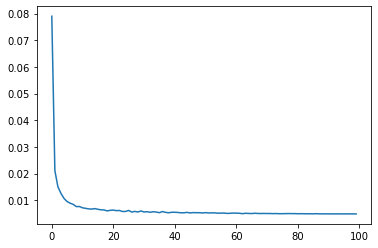

In [26]:
import matplotlib.pyplot as plt
f = pd.DataFrame(loss_values)
f.columns=['Loss']
fig = plt.plot(f.index, f.Loss)
plt.show()

In [27]:

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(test.shape[0]))
# Create sentence and label lists
sentences = test.sentence.values
labels = test.drop(columns=['sentence']).values
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")
labels = torch.tensor(labels,dtype=torch.long)
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask) 
# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
# Set the batch size.  
batch_size = 32  
# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 24,956



/tmp/ipykernel_3269587/2840356787.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prediction_labels = torch.tensor(labels)


In [28]:
import tensorflow as tf
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))
# Put model in evaluation mode
model.eval()
# Tracking variables 
predictions , true_labels, prediction_probs = [], [],[] #Atefeh
# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
  
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)
    logits = outputs[0]
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
    prediction_probs.append (tf.nn.softmax(logits))

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)
print('DONE.')

Predicting labels for 24,956 test sentences...


2024-01-17 07:15:02.054267: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-17 07:15:03.329972: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10334 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-01-17 07:15:03.331909: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 37762 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0


DONE.


In [29]:
prediction_probs[:1]

[<tf.Tensor: shape=(32, 9), dtype=float32, numpy=
 array([[6.22444689e-01, 1.65851310e-01, 1.15985945e-02, 3.11484803e-02,
         4.32324372e-02, 5.88131547e-02, 5.42921852e-03, 2.52355654e-02,
         3.62465233e-02],
        [5.69425344e-01, 8.64308998e-02, 2.09383313e-02, 1.14648640e-01,
         8.25062916e-02, 3.67880985e-02, 1.79938357e-02, 2.78835669e-02,
         4.33848947e-02],
        [4.04815292e-10, 2.86529567e-11, 3.05764615e-11, 5.99719788e-11,
         1.00000000e+00, 3.19264164e-11, 1.02506658e-11, 1.33177488e-11,
         2.78784443e-11],
        [1.00000000e+00, 2.71890732e-09, 2.56710986e-09, 4.04560829e-09,
         4.84770624e-09, 2.84280555e-09, 1.26448407e-09, 1.77195869e-09,
         1.89943949e-09],
        [7.56633645e-10, 1.00000000e+00, 4.02153102e-11, 9.66286079e-11,
         1.26722133e-10, 7.88477686e-11, 4.02344165e-11, 2.66961869e-11,
         4.34139218e-11],
        [4.25945501e-10, 2.76735770e-11, 3.11600884e-11, 5.80479519e-11,
         1.000000

In [30]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, matthews_corrcoef, classification_report
accs_set = []
print(predictions[0].shape)
# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')
# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
    true_labels_i = np.argmax(true_labels[i], axis=1).flatten()
    #print(pred_labels_i)
  # Calculate and store the coef for this batch.  
    acc = accuracy_score(true_labels_i, pred_labels_i)                
    accs_set.append(acc)

(32, 9)
Calculating Matthews Corr. Coef. for each batch...


In [31]:
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]
flat_true_labels = np.argmax(flat_true_labels, axis=1).flatten()
# Calculate the MCC
acc = accuracy_score(flat_true_labels, flat_predictions)
print('ACC: %.3f' % acc)

ACC: 0.990


In [32]:
confusion_matrix=confusion_matrix(flat_true_labels, flat_predictions)
confusion_matrix

array([[6624,   14,    1,   27,   25,    9,    9,    0,    1],
       [   0, 2430,    0,    0,    0,    0,    1,    0,    0],
       [   2,    2,  788,    5,    3,    0,    1,    1,    0],
       [   8,    2,    1, 3254,   24,    2,    0,    0,    0],
       [  23,    2,    2,   18, 5721,    6,    0,    4,    2],
       [   0,    3,    1,    1,    7, 2089,   12,    1,    2],
       [   3,    0,    0,    6,    9,   17, 1667,    0,    0],
       [   0,    0,    0,    0,    1,    0,    0,  528,    0],
       [   1,    0,    0,    0,    0,    1,    0,    0, 1595]])

In [33]:
print(classification_report(flat_true_labels, flat_predictions, digits=4))

              precision    recall  f1-score   support

           0     0.9944    0.9872    0.9908      6710
           1     0.9906    0.9996    0.9951      2431
           2     0.9937    0.9825    0.9881       802
           3     0.9828    0.9888    0.9858      3291
           4     0.9881    0.9901    0.9891      5778
           5     0.9835    0.9872    0.9854      2116
           6     0.9864    0.9794    0.9829      1702
           7     0.9888    0.9981    0.9934       529
           8     0.9969    0.9987    0.9978      1597

    accuracy                         0.9896     24956
   macro avg     0.9895    0.9902    0.9898     24956
weighted avg     0.9896    0.9896    0.9896     24956



['Metaphor/Similie' 'Rhetorical question' 'Story/Anecdote' 'Contrast'
 'Lists/Repetitions' 'Sentiment of the Collective' 'Moral Conviction'
 'Ambitious goals' 'Confidence in goals']


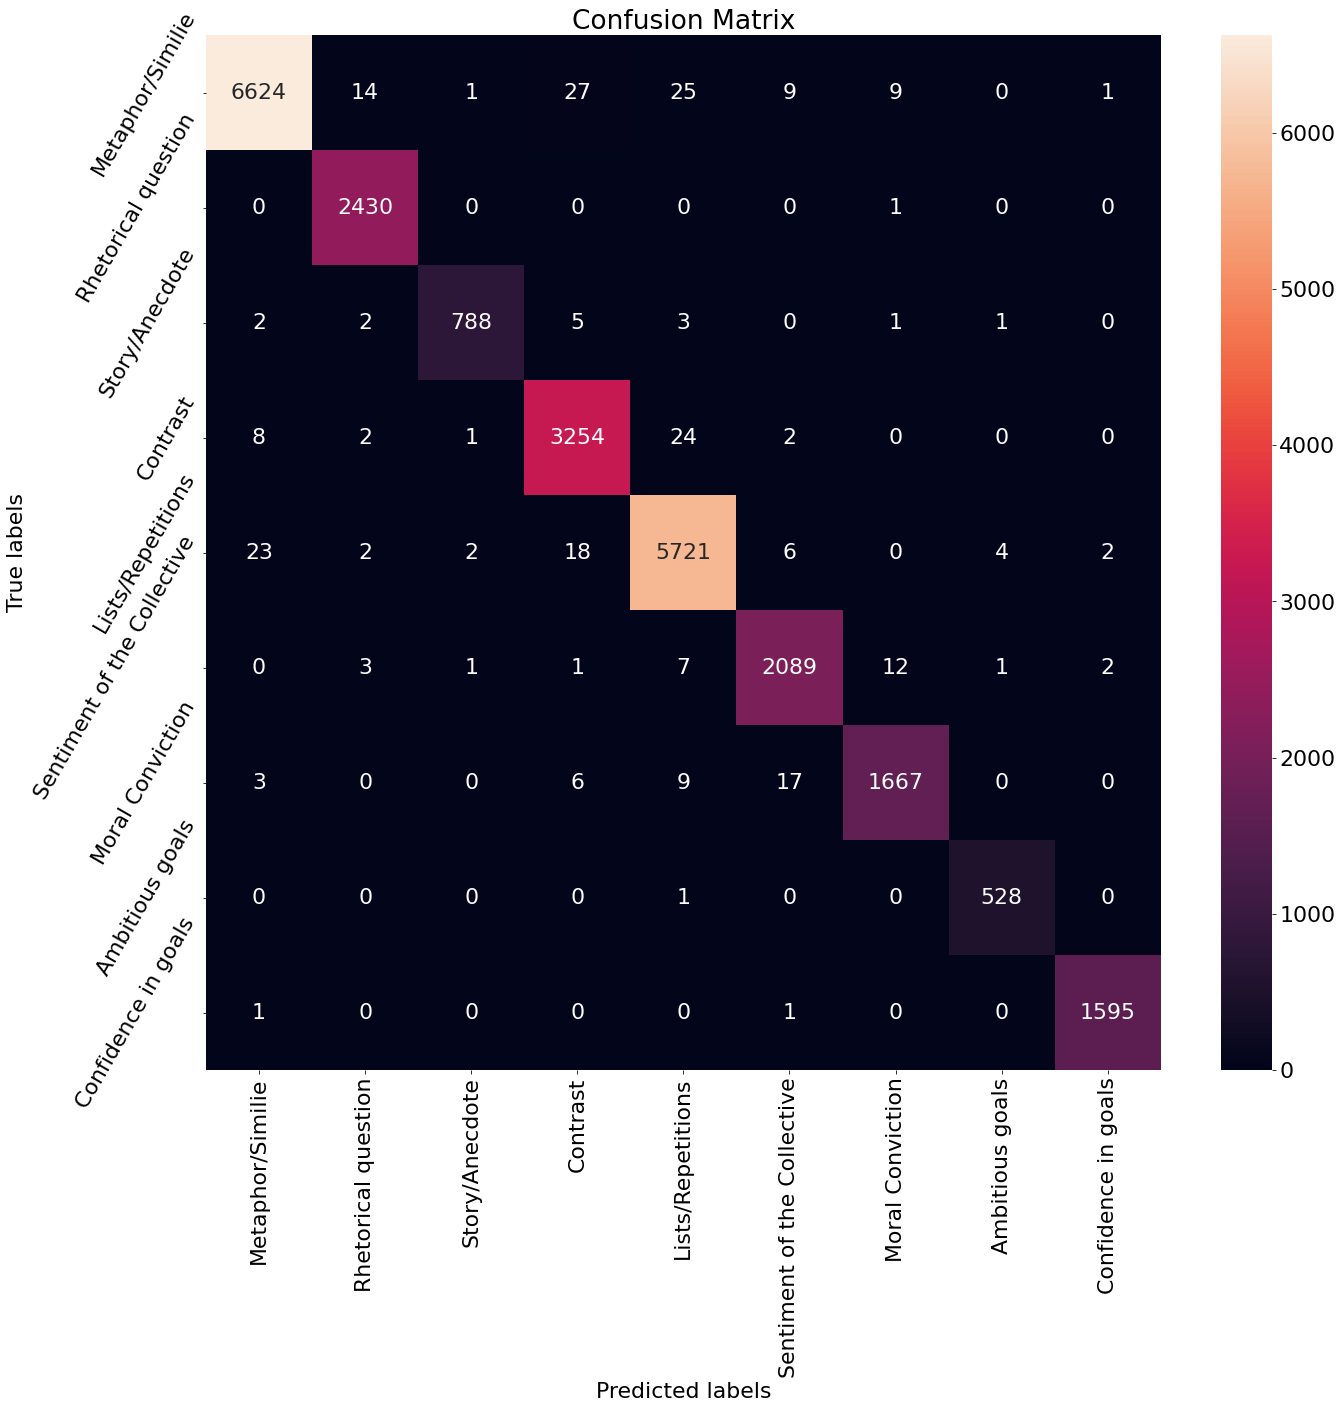

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
labels = data.keys().values
print(labels[1:])
fig, ax = plt.subplots( figsize=(20, 20))
sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels[1:],rotation=90)
ax.yaxis.set_ticklabels(labels[1:],rotation=60)
plt.tight_layout()
plt.savefig('plots/CharismaBERT_confusion_matrix.png')